In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Electricity/steel_energy.csv')
dfi

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [3]:
dfi['date'] = pd.to_datetime(dfi['date'], format='%d/%m/%Y %H:%M')
dfi

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,2018-12-31 23:45:00,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [4]:
dfi.drop(['WeekStatus','Day_of_week','Load_Type'],axis=1,inplace=True)

<Axes: >

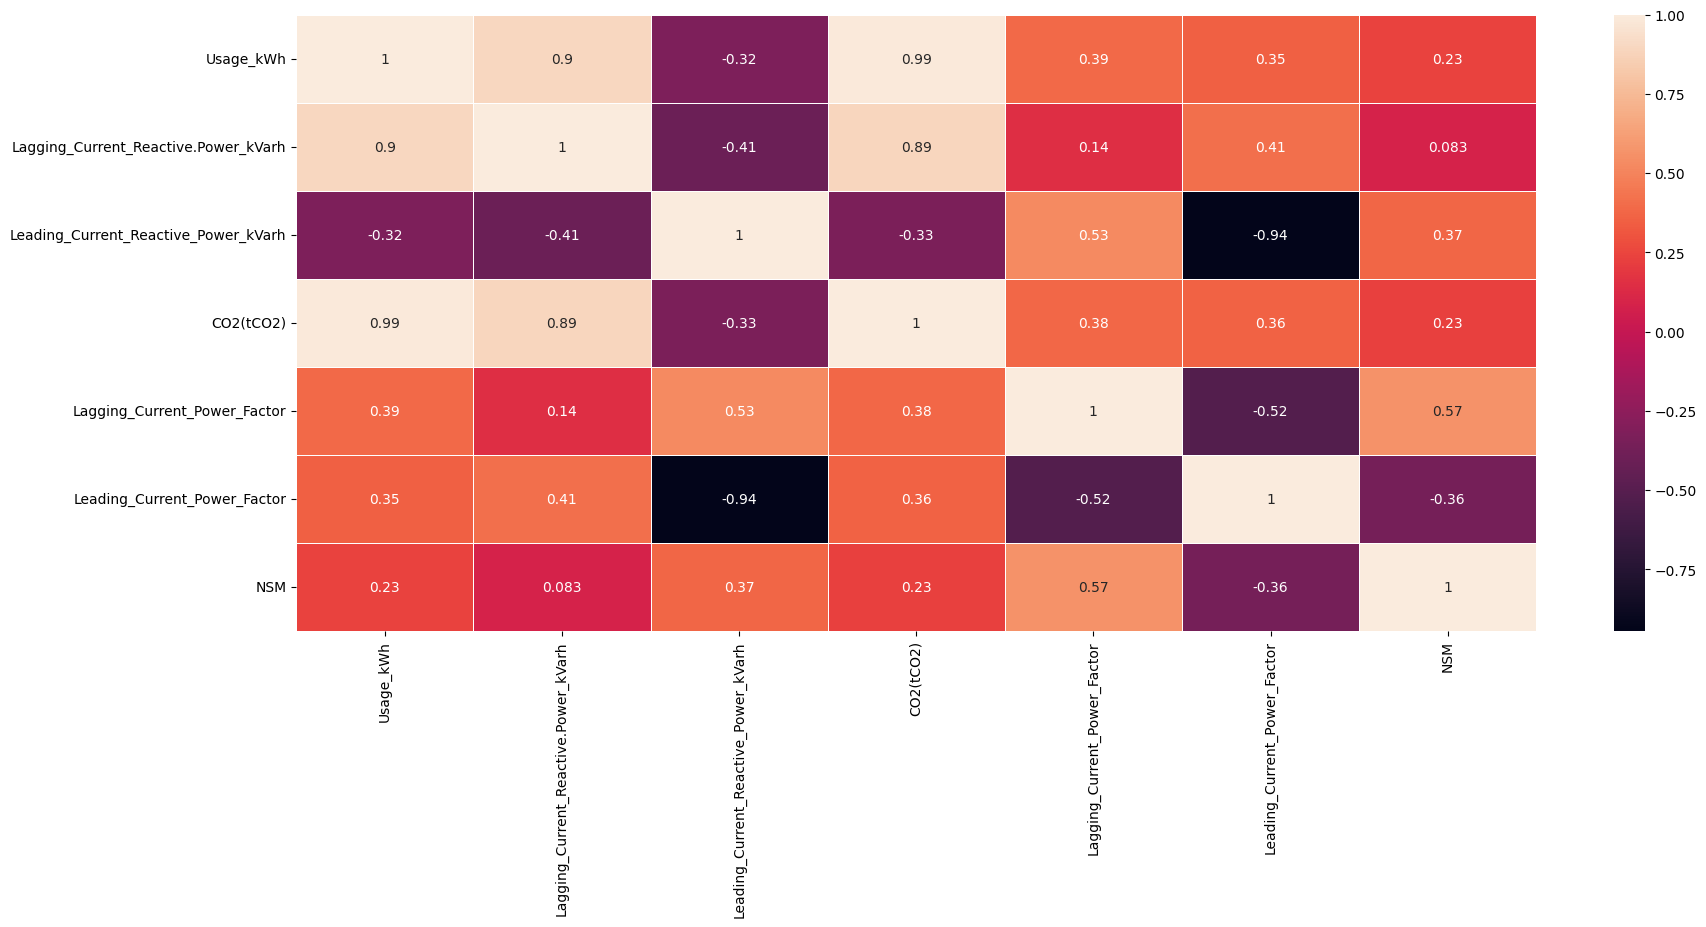

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))
corr = dfi.select_dtypes('number').corr()
sns.heatmap(data=corr, annot=True, linewidths=.5,ax=ax)

In [6]:
dfi = dfi.groupby([pd.Grouper(freq='H', key='date')]).mean().reset_index()
dfi

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
0,2018-01-01 00:00:00,3.4575,3.5375,0.0000,0.0,70.1400,100.000,1350.0
1,2018-01-01 01:00:00,3.5025,3.9400,0.0000,0.0,66.5475,100.000,4950.0
2,2018-01-01 02:00:00,3.5300,4.1675,0.0000,0.0,64.7400,100.000,8550.0
3,2018-01-01 03:00:00,3.4550,4.0500,0.0000,0.0,65.0675,100.000,12150.0
4,2018-01-01 04:00:00,3.6175,4.4100,0.0000,0.0,63.5175,100.000,15750.0
...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,3.9500,0.0000,18.0175,0.0,100.0000,21.675,69750.0
8756,2018-12-31 20:00:00,3.7800,0.0000,16.7325,0.0,100.0000,22.445,73350.0
8757,2018-12-31 21:00:00,3.4375,0.0000,13.3675,0.0,100.0000,24.905,76950.0
8758,2018-12-31 22:00:00,3.5375,3.0875,3.3225,0.0,74.3450,81.270,80550.0


In [7]:
df = dfi.loc[dfi['date'] > '2018-07-01']
df.reset_index(inplace=True)
df = df[['Lagging_Current_Reactive.Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Usage_kWh']]
#df.drop(['date','Leading_Current_Reactive_Power_kVarh','NSM'],axis=1,inplace=True)
df

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh
0,4.0250,0.0,57.8175,100.000,2.8525
1,4.0850,0.0,57.4850,100.000,2.8700
2,4.0850,0.0,62.6675,100.000,3.3100
3,3.7875,0.0,59.5875,100.000,2.8100
4,3.7875,0.0,59.3075,100.000,2.7900
...,...,...,...,...,...
4410,0.0000,0.0,100.0000,21.675,3.9500
4411,0.0000,0.0,100.0000,22.445,3.7800
4412,0.0000,0.0,100.0000,24.905,3.4375
4413,3.0875,0.0,74.3450,81.270,3.5375


In [8]:
df.ffill()

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh
0,4.0250,0.0,57.8175,100.000,2.8525
1,4.0850,0.0,57.4850,100.000,2.8700
2,4.0850,0.0,62.6675,100.000,3.3100
3,3.7875,0.0,59.5875,100.000,2.8100
4,3.7875,0.0,59.3075,100.000,2.7900
...,...,...,...,...,...
4410,0.0000,0.0,100.0000,21.675,3.9500
4411,0.0000,0.0,100.0000,22.445,3.7800
4412,0.0000,0.0,100.0000,24.905,3.4375
4413,3.0875,0.0,74.3450,81.270,3.5375


In [9]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lagging_Current_Reactive.Power_kVarh,4415.0,12.927970,14.500337,0.0000,2.88000,5.4800,23.05375,66.2400
CO2(tCO2),4415.0,0.010361,0.014130,0.0000,0.00000,0.0000,0.02250,0.0650
Lagging_Current_Power_Factor,4415.0,78.858537,19.804580,37.2975,56.88750,87.0500,95.76500,100.0000
Leading_Current_Power_Factor,4415.0,83.748893,28.360197,13.0850,80.78125,100.0000,100.00000,100.0000
Usage_kWh,4415.0,24.825906,29.352665,2.4650,3.06000,4.0575,48.73500,136.6475


In [10]:
df['nxt_target'] = df['Usage_kWh'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
df

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh,nxt_target
0,4.0250,0.0,57.8175,100.000,2.8525,2.8700
1,4.0850,0.0,57.4850,100.000,2.8700,3.3100
2,4.0850,0.0,62.6675,100.000,3.3100,2.8100
3,3.7875,0.0,59.5875,100.000,2.8100,2.7900
4,3.7875,0.0,59.3075,100.000,2.7900,2.7825
...,...,...,...,...,...,...
4410,0.0000,0.0,100.0000,21.675,3.9500,3.7800
4411,0.0000,0.0,100.0000,22.445,3.7800,3.4375
4412,0.0000,0.0,100.0000,24.905,3.4375,3.5375
4413,3.0875,0.0,74.3450,81.270,3.5375,3.7875


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Lagging_Current_Reactive.Power_kVarh  4415 non-null   float64
 1   CO2(tCO2)                             4415 non-null   float64
 2   Lagging_Current_Power_Factor          4415 non-null   float64
 3   Leading_Current_Power_Factor          4415 non-null   float64
 4   Usage_kWh                             4415 non-null   float64
 5   nxt_target                            4415 non-null   float64
dtypes: float64(6)
memory usage: 207.1 KB


In [12]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh,nxt_target
0,4.0250,0.0,57.8175,100.0000,2.8525,2.8700
1,4.0850,0.0,57.4850,100.0000,2.8700,3.3100
2,4.0850,0.0,62.6675,100.0000,3.3100,2.8100
3,3.7875,0.0,59.5875,100.0000,2.8100,2.7900
4,3.7875,0.0,59.3075,100.0000,2.7900,2.7825
...,...,...,...,...,...,...
3527,2.6000,0.0,76.6975,99.9950,3.1050,3.0775
3528,2.5725,0.0,76.8200,99.9925,3.0775,3.0850
3529,2.6200,0.0,76.2075,99.9925,3.0850,2.8900
3530,2.6750,0.0,73.3925,100.0000,2.8900,2.8800


In [13]:
train.iloc[:,-1:]

,nxt_target
0,2.8700
1,3.3100
2,2.8100
3,2.7900
4,2.7825
...,...
3527,3.0775
3528,3.0850
3529,2.8900
3530,2.8800


In [14]:
train.iloc[:,:5]

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh
0,4.0250,0.0,57.8175,100.0000,2.8525
1,4.0850,0.0,57.4850,100.0000,2.8700
2,4.0850,0.0,62.6675,100.0000,3.3100
3,3.7875,0.0,59.5875,100.0000,2.8100
4,3.7875,0.0,59.3075,100.0000,2.7900
...,...,...,...,...,...
3527,2.6000,0.0,76.6975,99.9950,3.1050
3528,2.5725,0.0,76.8200,99.9925,3.0775
3529,2.6200,0.0,76.2075,99.9925,3.0850
3530,2.6750,0.0,73.3925,100.0000,2.8900


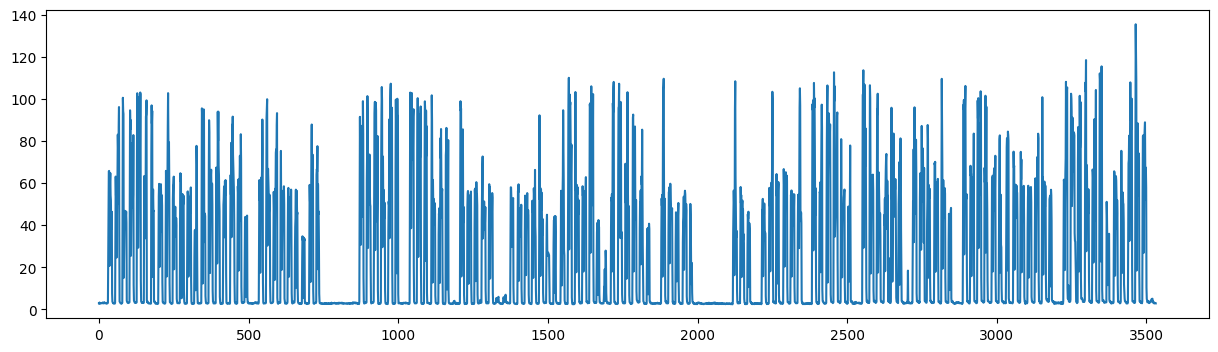

In [15]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Usage_kWh"])
plt.show()

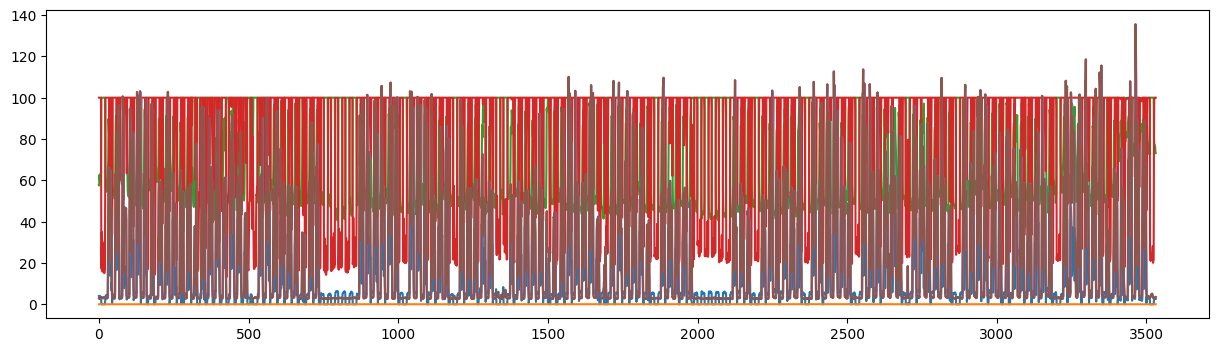

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [17]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:5])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [18]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 5
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 5
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [19]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [20]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [21]:
print(X_train.shape)
X_train[0][0]

torch.Size([3522, 10, 5])


tensor([-0.6615, -0.7520, -0.8921,  0.5581, -0.7610])

In [22]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        #print('av',len(x.size()))
        if self.batch_first is True and len(x.size()) == 3:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            #h_t = h_t[0]
            #c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            #x_t = x[:, t, :]
            
            #x_t = x[:, t]
            # Concatenate input and hidden 
            x_t = x
            #print('x',x.size())
            #print('t',t)
            #print('xt',x_t.size())
            #print('ht',h_t.size())
            v_t = torch.cat((x_t, h_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [23]:
device = "cpu"

In [24]:
class AttnEncoder(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.lstm = QLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, input_data: torch.Tensor):
        
        if self.batch_first is True and len(input_data.size())==3:
            batch_size, seq_length, features_size = input_data.size()
        else:
            batch_size, features_size = input_data.size()

        h_t = Variable(torch.zeros(batch_size, self.hidden_size))  # hidden state (output)
        c_t = Variable(torch.zeros(batch_size, self.hidden_size))  # cell state

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))


        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            #self.lstm.flatten_parameters()
            #print('x,et,at',x.size(), e_t.size(), a_t.size())
            #print('atinputdaata',input_data[:,t,:].size())
            #print('winput',weighted_input.size())
            
            _, (h_t, c_t) = self.lstm(weighted_input, (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [25]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AttnDecoder, self).__init__()
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.lstm = QLSTM(
            input_size=1,
            hidden_size=hidden_size,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        if self.batch_first is True and len(input_encoded.size())==3:
            batch_size, seq_length, features_size = input_encoded.size()
        else:
            batch_size, features_size = input_encoded.size()
        
        h_t = Variable(torch.zeros(batch_size, self.decoder_hidden_size))  # hidden state (output)
        c_t = Variable(torch.zeros(batch_size, self.decoder_hidden_size))  # cell state
        
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
           # print('con_yhis',context.size(),y_history.size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            #self.lstm.flatten_parameters()
           # print('ytilde', y_tilde.size())
            _, (h_t, c_t) = self.lstm(y_tilde, (h_t, c_t))
        #print('ht_con', h_t.size(),context.size())
        return self.fc_out(torch.cat((h_t, context.to(device)), dim=1))  # predicting value at t=self.seq_length+1


In [26]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first, n_qubits, n_qlayers,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, n_qubits, n_qlayers,seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [27]:
batch_size = 5
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=5, hidden_size= 12, n_qubits=5)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 5)
weight_shapes = (n_qlayers, n_qubits) = (1, 5)


In [28]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:71.64038154781883 
[2/5]  LossQ:2.4828619792656355 
[3/5]  LossQ:1.7195734089167445 


In [ ]:
torch.save(modelQ.state_dict(),'./SavedModels/Electricity/steel_energy/model/QLSTM_attn_sd')

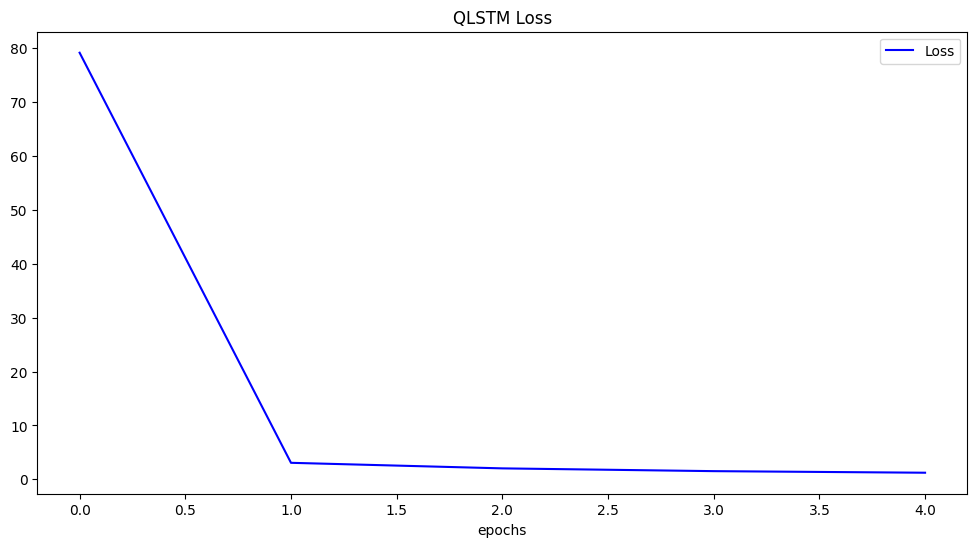

In [ ]:
np.savetxt('./SavedModels/Electricity/steel_energy/loss/qlstm_attn.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [ ]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

873
3522
3522


In [ ]:
#modelQ.load_state_dict(torch.load('./SavedModels/Electricity/RE_elecDemand/model/QLSTM_attn_sd'))

<All keys matched successfully>

In [ ]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [ ]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

873
tensor([[-3.8854e-01],
        [-6.3000e-02],
        [-1.9678e-01],
        [-3.6932e-01],
        [-4.2048e-01],
        [-5.7884e-01],
        [-8.1224e-01],
        [-1.0649e+00],
        [-1.3047e+00],
        [-1.4709e+00],
        [-1.5517e+00],
        [-1.5886e+00],
        [-1.5669e+00],
        [-1.3779e+00],
        [-1.0713e+00],
        [-1.0034e+00],
        [-1.1792e+00],
        [-1.4351e+00],
        [-1.6102e+00],
        [-1.7140e+00],
        [-1.6816e+00],
        [-1.5387e+00],
        [-1.1954e+00],
        [-6.2150e-01],
        [-5.5535e-02],
        [ 5.2417e-01],
        [ 4.8113e-01],
        [ 3.0654e-01],
        [ 1.3034e-01],
        [-8.0092e-02],
        [-4.2501e-01],
        [-8.0443e-01],
        [-1.1335e+00],
        [-1.3579e+00],
        [-1.4839e+00],
        [-1.5449e+00],
        [-1.5276e+00],
        [-1.3976e+00],
        [-1.1703e+00],
        [-1.1403e+00],
        [-1.3163e+00],
        [-1.5166e+00],
        [-1.6497e+00],
       

In [ ]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

3522
tensor([[ 0.6194],
        [ 0.9213],
        [ 1.2580],
        ...,
        [-1.2904],
        [-1.2855],
        [-1.2224]])


In [ ]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [ ]:
print(len(pred_y_train))
print(len(y_train))

3522
3522


In [ ]:
pred_y_test

tensor([[-3.8854e-01],
        [-6.3000e-02],
        [-1.9678e-01],
        [-3.6932e-01],
        [-4.2048e-01],
        [-5.7884e-01],
        [-8.1224e-01],
        [-1.0649e+00],
        [-1.3047e+00],
        [-1.4709e+00],
        [-1.5517e+00],
        [-1.5886e+00],
        [-1.5669e+00],
        [-1.3779e+00],
        [-1.0713e+00],
        [-1.0034e+00],
        [-1.1792e+00],
        [-1.4351e+00],
        [-1.6102e+00],
        [-1.7140e+00],
        [-1.6816e+00],
        [-1.5387e+00],
        [-1.1954e+00],
        [-6.2150e-01],
        [-5.5535e-02],
        [ 5.2417e-01],
        [ 4.8113e-01],
        [ 3.0654e-01],
        [ 1.3034e-01],
        [-8.0092e-02],
        [-4.2501e-01],
        [-8.0443e-01],
        [-1.1335e+00],
        [-1.3579e+00],
        [-1.4839e+00],
        [-1.5449e+00],
        [-1.5276e+00],
        [-1.3976e+00],
        [-1.1703e+00],
        [-1.1403e+00],
        [-1.3163e+00],
        [-1.5166e+00],
        [-1.6497e+00],
        [-1

In [ ]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [ ]:
np.savetxt('./SavedModels/Electricity/steel_energy/train/qlstm_attn.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/steel_energy/test/qlstm_attn.txt',y_test_pred)

Training dataset RMSE:399.8991174987664


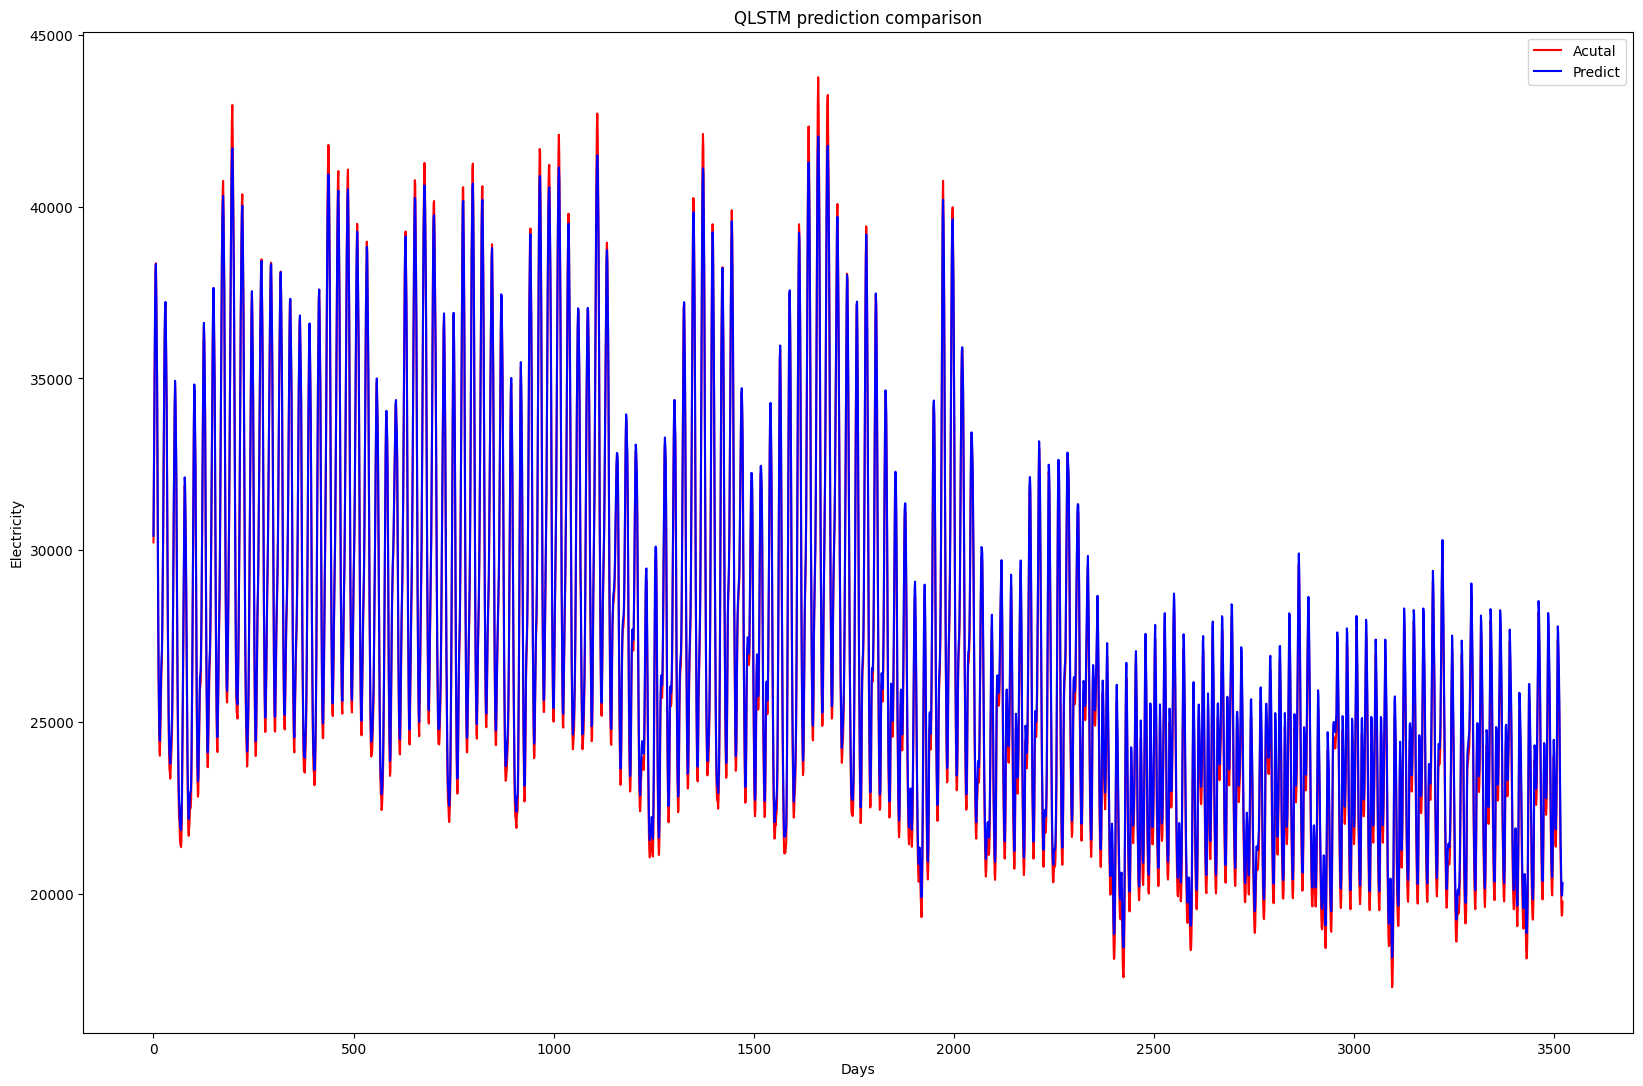

In [ ]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:230.3295214888836


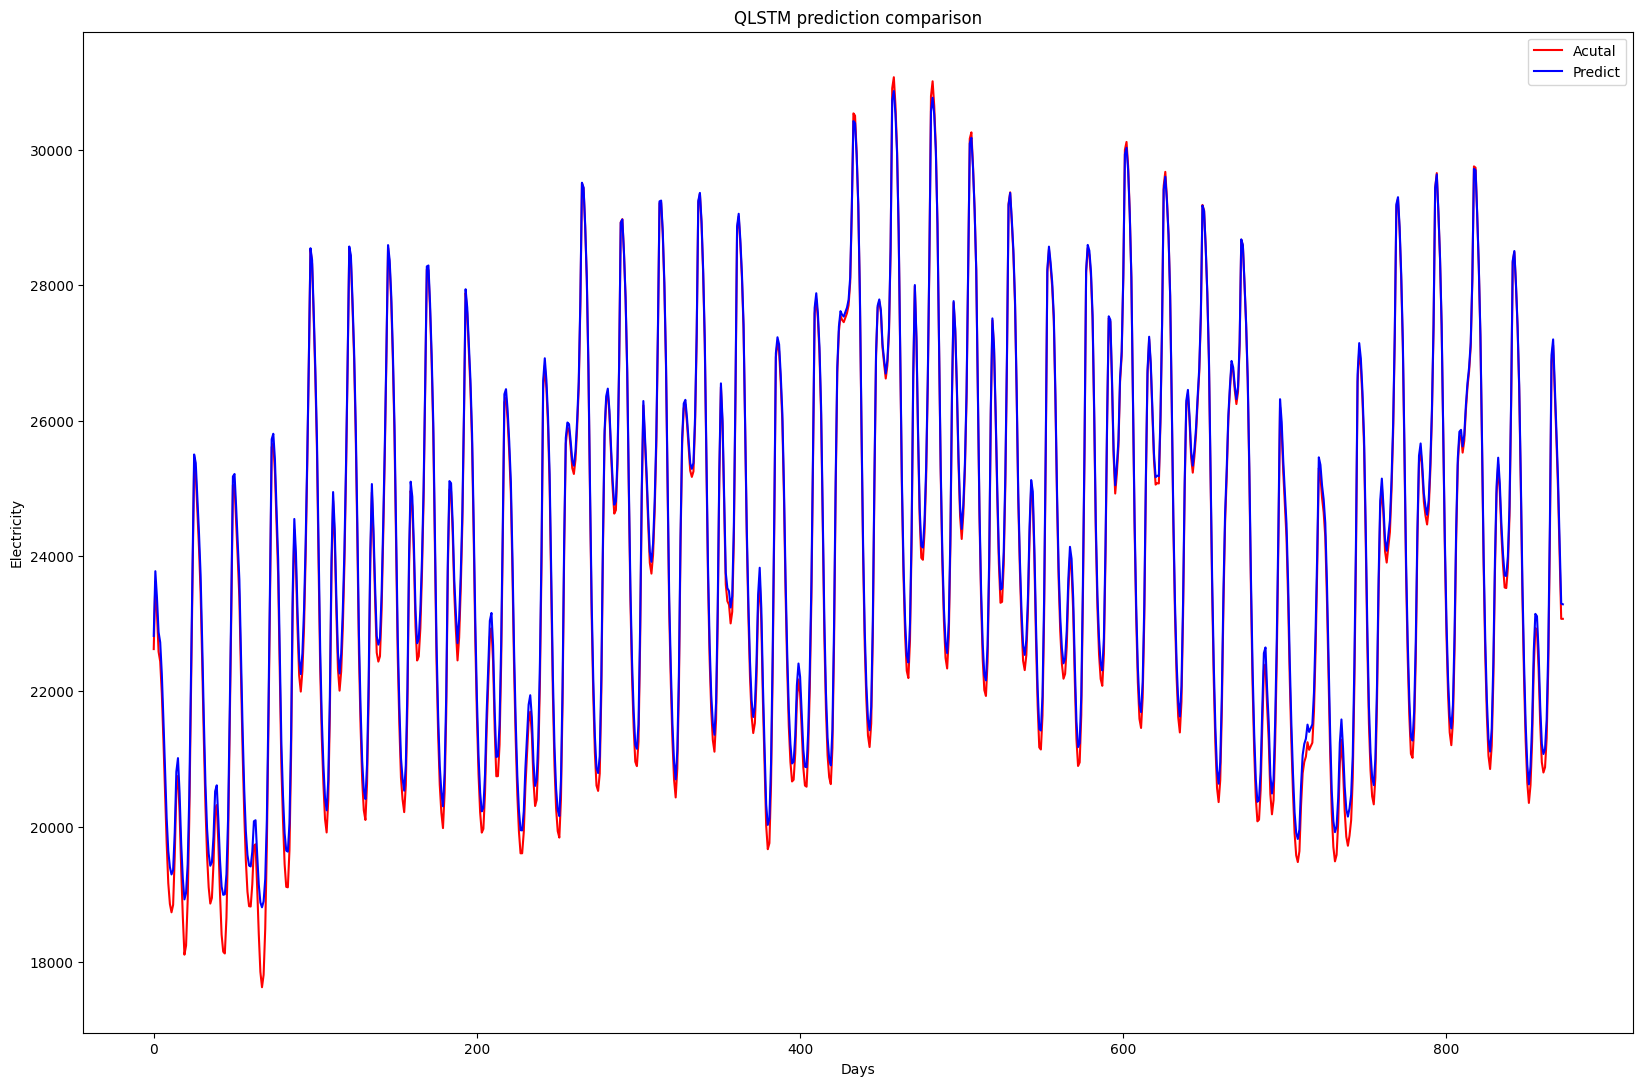

In [ ]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')